Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import requests
from io import BytesIO

Load a pre-trained CNN (VGG16)

A forward hook is registered to capture the feature map (activation) of a specific convolutional layer (10th layer).

    This stores the activation in activations["layer"], which contains the feature maps extracted at that layer

In [ ]:
model = models.vgg16(pretrained=True).features.eval()

# Define a hook to capture activations
activations = {}

def hook_fn(module, input, output):
    activations["layer"] = output.detach()

# Register hook for a specific layer (e.g., 10th layer of VGG16)
layer_index = 10  # Choose a convolutional layer
model[layer_index].register_forward_hook(hook_fn)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.8MB/s]


Function to load images from URL

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

# Image preprocessing function
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

Function to generate activation heatmap

In [ ]:
def generate_heatmap(img, activations, neuron_index):
    activation = activations["layer"].squeeze(0)[neuron_index].cpu().numpy()
    activation = cv2.resize(activation, (img.size[0], img.size[1]))  # Resize to original image size

    # Normalize activation
    activation = np.maximum(activation, 0)
    activation /= activation.max()

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * activation), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on image
    img = np.array(img)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return overlay

Load images

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(url):
    """Fetch image from URL and convert it to PIL format."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(url, headers=headers, stream=True)

    if response.status_code == 200:
        try:
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return img
        except Exception as e:
            print(f"Error decoding image from {url}: {e}")
            return None
    else:
        print(f"Failed to fetch image. HTTP Status: {response.status_code}")
        return None

# Test URLs
monument_url = "https://upload.wikimedia.org/wikipedia/commons/a/a8/Tour_Eiffel_Wikimedia_Commons.jpg"
mountain_url = "https://upload.wikimedia.org/wikipedia/commons/5/51/Matterhorn-600px.jpg"
animal_url = "https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg"

# Load the images
monument = load_image_from_url(monument_url)
mountain = load_image_from_url(mountain_url)
animal = load_image_from_url(animal_url)

# Display images if successfully loaded
if monument:
    monument.show()
if mountain:
    mountain.show()
if animal:
    animal.show()


Process each image and visualize activations

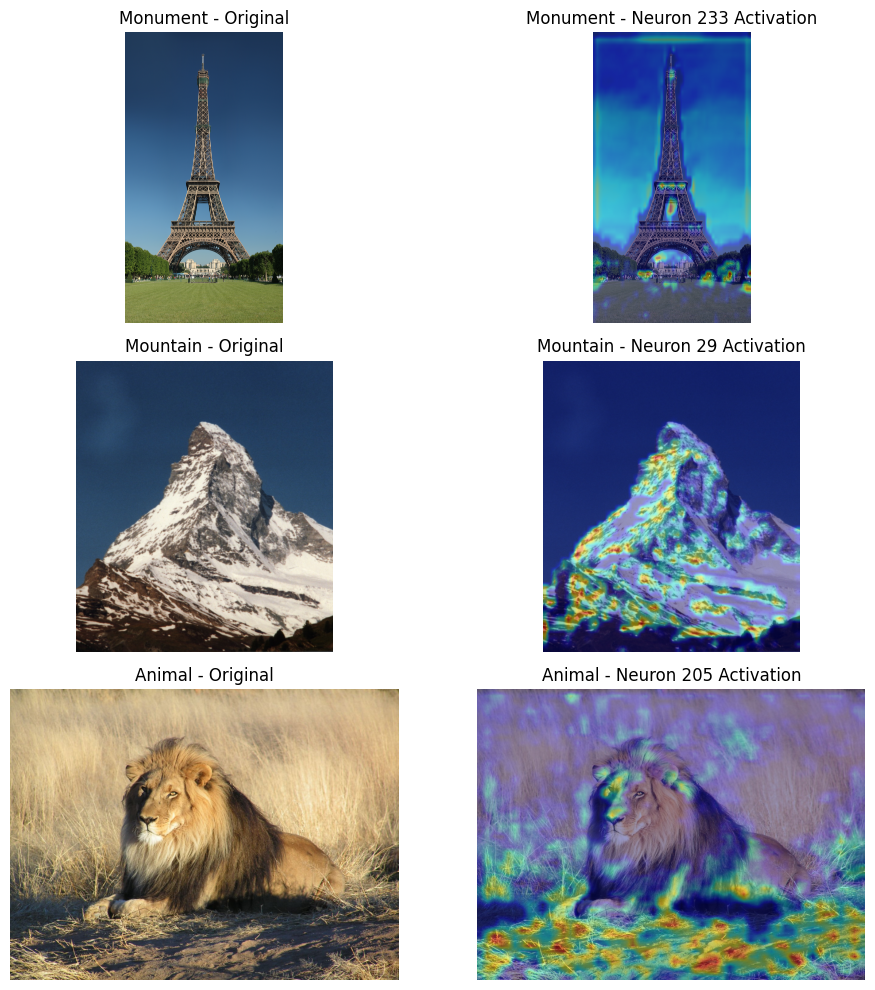

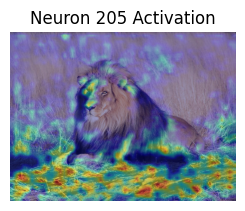

In [ ]:
images = [("Monument", monument), ("Mountain", mountain), ("Animal", animal)]

plt.figure(figsize=(10, 10))

for i, (title, img) in enumerate(images):
    img, img_tensor = preprocess_image(img)
    _ = model(img_tensor)  # Forward pass to capture activations

    # Choose the neuron with the highest average activation
    neuron_index = activations["layer"].squeeze(0).mean(dim=(1, 2)).argmax().item()

    # Generate heatmap visualization
    heatmap_overlay = generate_heatmap(img, activations, neuron_index)

    # Display results
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(img)
    plt.title(f"{title} - Original")
    plt.axis("off")

    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(heatmap_overlay)
    plt.title(f"{title} - Neuron {neuron_index} Activation")
    plt.axis("off")

plt.tight_layout()
plt.show()


plt.subplot(1, 2, 2)
plt.imshow(heatmap_overlay)
plt.title(f"Neuron {neuron_index} Activation")
plt.axis("off")

plt.show()

Summary of What This Code Does

    Loads a pre-trained VGG16 model and selects a convolutional layer.

    Registers a hook to capture feature maps.

    Loads an image from a URL, preprocesses it, and performs a forward pass.

    Identifies the most activated neuron in the selected layer.

    Generates a heatmap to visualize which parts of the image contribute to that neuron’s activation.

    Displays both the original image and the activation heatmap.